Nama: Shelly Victory;
User Name: victorysl;
Alamat Email: shellyvicotry92@gmail.com;
Dataset source: https://www.kaggle.com/jaganadhg/house-hold-energy-data

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Activation
from keras.callbacks import ReduceLROnPlateau
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [2]:
import os
os.listdir('sample_data')
import pandas as pd
data = pd.read_csv('sample_data/data.csv')
del data ['NOTES']
data.tail()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01
70367,Electric usage,10/24/2018,23:45,23:59,0.03,kWh,$0.01


In [3]:
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00


In [4]:
# identify unique data based on its date
pd.Series(data['DATE'].unique()).sort_index(ascending=True)

0      10/22/2016
1      10/23/2016
2      10/24/2016
3      10/25/2016
4      10/26/2016
          ...    
728    10/20/2018
729    10/21/2018
730    10/22/2018
731    10/23/2018
732    10/24/2018
Length: 733, dtype: object

In [5]:
data1 = pd.date_range('2016-10-22', '2018-10-24', freq='D').to_series()
data1.dt.dayofweek # The number of unique columns on df = number of date range from the beginning until the end

2016-10-22    5
2016-10-23    6
2016-10-24    0
2016-10-25    1
2016-10-26    2
             ..
2018-10-20    5
2018-10-21    6
2018-10-22    0
2018-10-23    1
2018-10-24    2
Freq: D, Length: 733, dtype: int64

In [6]:
data.isnull().sum()

TYPE          0
DATE          0
START TIME    0
END TIME      0
USAGE         0
UNITS         0
COST          0
dtype: int64

In [7]:
data.dtypes

TYPE           object
DATE           object
START TIME     object
END TIME       object
USAGE         float64
UNITS          object
COST           object
dtype: object

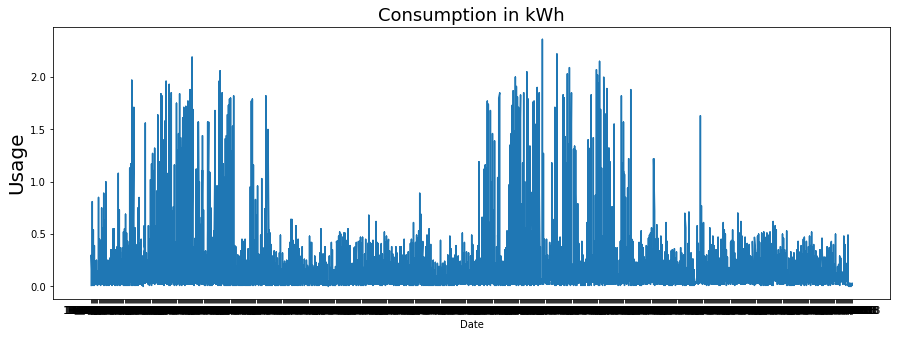

In [8]:
import matplotlib.pyplot as plt
x = data['DATE'].values
y = data['USAGE'].values

plt.figure(figsize=(15,5))
plt.plot(x, y)
plt.xlabel('Date',size=10)
plt.ylabel('Usage',size=20)
plt.title('Consumption in kWh',
          fontsize=18);

In [32]:
# membagi dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  data = tf.data.Dataset.from_tensor_slices(series)
  data = data.window(window_size + 1, shift=1, drop_remainder=True)
  data = data.flat_map(lambda w:w.batch(window_size + 1))
  data = data.shuffle(shuffle_buffer)
  data = data.map(lambda w: (w[:-1], w[-1:]))
  return data.batch(batch_size).prefetch(1)

In [34]:
train_set = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)

In [35]:
validation_set = windowed_dataset(y_test, window_size=60, batch_size=100, shuffle_buffer=10000)

In [36]:
from keras.layers import Conv1D
model=Sequential([
  Conv1D(filters=60, kernel_size=5, activation='relu', input_shape=[None, 1]),                
  LSTM(128, return_sequences=True),
  LSTM(64, return_sequences=False),
  Flatten(),
  Dense(32, activation="relu"),
  Dense(32, activation="relu"),
  Dense(units=1)
])

In [37]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [38]:
reduce = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, learning_rate=1.0000e-04)
history = model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[reduce])

Epoch 1/5
563/563 [==============================] - 176s 307ms/step - loss: 0.0271 - mae: 0.1033 - val_loss: 0.0052 - val_mae: 0.0656
Epoch 2/5
563/563 [==============================] - 164s 291ms/step - loss: 0.0244 - mae: 0.1129 - val_loss: 0.0052 - val_mae: 0.0751
Epoch 3/5
563/563 [==============================] - 163s 290ms/step - loss: 0.0241 - mae: 0.1187 - val_loss: 0.0052 - val_mae: 0.0783
Epoch 4/5
563/563 [==============================] - 165s 292ms/step - loss: 0.0240 - mae: 0.1205 - val_loss: 0.0053 - val_mae: 0.0792
Epoch 5/5
563/563 [==============================] - 164s 291ms/step - loss: 0.0239 - mae: 0.1210 - val_loss: 0.0053 - val_mae: 0.0795
